# Orthogonalization effect

---

Taken from the supplementary material of Cyril Pernet's article on GLM misconceptions

> **Misconceptions in the use of the General Linear Model applied to functional MRI: a tutorial for junior neuro-imagers.** Front. Neurosci., 21 January 2014, https://doi.org/10.3389/fnins.2014.00001

---

Simulation of event related designs analyzed using hrf+derivatives
to show the effect of orthogonalization on parameter estimates.


error: 'spm_get_bf' undefined near line 1 column 7
error: 'spm_hrf' undefined near line 12 column 23
error: 'T_var' undefined near line 7 column 44
error: Invalid call to test.  Correct usage is:

 -- test NAME
 -- test NAME quiet|normal|verbose
 -- test ("NAME", "quiet|normal|verbose", FID)
 -- test ("NAME", "quiet|normal|verbose", FNAME)
 -- SUCCESS = test (...)
 -- [N, NMAX, NXFAIL, NSKIP] = test (...)
 -- [CODE, IDX] = test ("NAME", "grabdemo")
 -- test ([], "explain", FID)
 -- test ([], "explain", FNAME)

Additional help for built-in functions and operators is
available in the online version of the manual.  Use the command
'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW
at http://www.octave.org and via the help@octave.org
mailing list.
error: 'test2' undefined near line 1 column 23
error: 'test2' undefined near line 2 column 8
error: 'data' undefined near line 3 column 23


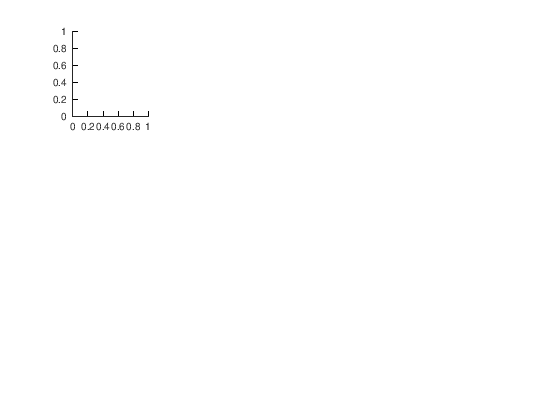

In [1]:
clear;

% get the hrf and derivative
xBF.dt = 0.5;
xBF.name = 'hrf (with time derivative)';
xBF.length = 32;
xBF.order = 1;
xBF = spm_get_bf(xBF);

%% simple periodic design
% -------------------------
index1 = 1;
scale = [15 5 10 10 5 15 10 5 15 10];

for shift = 0:2:4 % ie 0 +1 +2sec
    index2 = 1;

    for isi = 1:8 % fron 5sec isi to 40sec
        onsets = [1:10 * isi:100 * isi];
        Y1 = zeros(50 * isi, 1); % sampling at 2Hz
        X1 = zeros(50 * isi, 1);
        for i = 1:10
            Y1(onsets(i) + shift) = scale(i);
            X1(onsets(i)) = 1;
        end
        Y1 = conv(Y1, spm_hrf(0.5));

        clear SS;
        SS(:, 1) = conv(X1, xBF.bf(:, 1));
        SS(:, 2) = conv(X1, xBF.bf(:, 2));
        L = min(length(SS), length(Y1));
        Y1 = Y1(1:L) + 100;

        % --> design matrix with hrf only
        % -------------------------------
        X1 = [SS(1:L, 1) ones(L, 1)];
        beta1 = pinv(X1) * Y1;
        R = eye(size(Y1, 1)) - (X1 * pinv(X1));
        variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X1));
        C = [1 0];
        T(index1, index2, 1) = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
        T_var(index1, index2, 1) = variance;
        T_cov(index1, index2, 1) = (C * pinv(X1' * X1) * C');

        % --> design matrix with derivatives
        % ----------------------------------
        X2 = [SS(1:L, :) ones(L, 1)];
        beta2 = pinv(X2) * Y1;
        R = eye(size(Y1, 1)) - (X2 * pinv(X2));
        variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X2));
        C = [1 0 0];
        T(index1, index2, 2) = (C * beta2) ./ sqrt(variance .* (C * pinv(X2' * X2) * C'));
        T_var(index1, index2, 2) = variance;
        T_cov(index1, index2, 2) = (C * pinv(X2' * X2) * C');

        % --> derivatives forced to be orthogonal to hrf
        % ----------------------------------------------------------
        x = spm_orth(SS);
        X3 = [x(1:L, :) ones(L, 1)];
        beta3 = pinv(X3) * Y1;
        R = eye(size(Y1, 1)) - (X3 * pinv(X3));
        variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X3));
        C = [1 0 0];
        T(index1, index2, 3) = (C * beta3) ./ sqrt(variance .* (C * pinv(X3' * X3) * C'));
        T_var(index1, index2, 3) = variance;
        T_cov(index1, index2, 3) = (C * pinv(X3' * X3) * C');

        % --> derivatives forced to be orthogonal to [hrf constant]
        % ----------------------------------------------------------
        x = spm_orth2(SS);
        X4 = [x(1:L, :) ones(L, 1)];
        beta4 = pinv(X4) * Y1;
        R = eye(size(Y1, 1)) - (X4 * pinv(X4));
        variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X4));
        C = [1 0 0];
        T(index1, index2, 4) = (C * beta4) ./ sqrt(variance .* (C * pinv(X4' * X4) * C'));
        T_var(index1, index2, 4) = variance;
        T_cov(index1, index2, 4) = (C * pinv(X4' * X4) * C');

        % record beta(1) parameters + correlations between regressors
        % -----------------------------------------------------------
        data(index1, index2, :) = [beta1(1) beta2(1) beta3(1) beta4(1)];
        % correlation hrf / ones
        cos_theta1(index1, index2) =  (dot(X1(:, 1), X1(:, 2))) / (norm(X1(:, 1)) * norm(X1(:, 2)));
        % correlation derivative / ones
        cos_theta2(index1, index2) =  (dot(SS(1:L, 2), X1(:, 2))) / (norm(SS(1:L, 2)) * norm(X1(:, 2)));
        index2 = index2 + 1;
    end
    index1 = index1 + 1;
end

% check the behaviour of T values
% all model provide the same data fit so the variance should be the same
% only covariance increases
% 1 - check there is a unique variance value for all models
% 2 - check that on average the covariance is higher in models 2 and 3
for shift = 1:3
    test(shift) = mean(mean(single(squeeze(T_var(shift, :, 2:4))) ==  single(repmat(mean(unique(squeeze(T_var(shift, :, 2:4))', 'rows'))', 1, 3))));
    test2(shift, :) = mean(squeeze(T_cov(shift, :, :)));
end

if sum(test) == 3
    fprintf('all model have the same variance \n');
end

test2 = unique(repmat(test2(:, 1), 1, 3) - test2(:, 2:4));
for model = 1:3
    if test2(model) < 0
        fprintf('but covariance of model %g is larger of %g \n', model, abs(test2(model)));
    elseif test2(model) == 0
        fprintf('and covariance of model %g is identical as hrf only \n', model);
    end
end

% figure
s = [0 1 2]; % shift in sec
isi = [5:5:40]; % isi in sec
figure;
index = 1;
for shift = 1:3
    subplot(3, 4, index);
    plot(isi, squeeze(data(shift, :, 1)), 'LineWidth', 3);
    grid on;
    hold on;
    plot(isi, squeeze(data(shift, :, 2)), 'k', 'LineWidth', 3);
    plot(isi, squeeze(data(shift, :, 3)), '--g', 'LineWidth', 3);
    plot(isi, squeeze(data(shift, :, 4)), '--r', 'LineWidth', 3);
    ylabel('beta parameters', 'Fontsize', 14);
    xlabel('ISI', 'Fontsize', 14);
    axis tight;
    title(['shift of ' num2str(s(shift)) ' sec'], 'Fontsize', 14);

    subplot(3, 4, index + 1);
    plot(fliplr(cos_theta1(1, :)), squeeze(data(shift, :, 1)), 'LineWidth', 3);
    grid on;
    hold on;
    plot(fliplr(cos_theta1(1, :)), squeeze(data(shift, :, 2)), 'k', 'LineWidth', 3);
    plot(fliplr(cos_theta1(1, :)), squeeze(data(shift, :, 3)), '--g', 'LineWidth', 3);
    plot(fliplr(cos_theta1(1, :)), squeeze(data(shift, :, 4)), '--r', 'LineWidth', 3);
    ylabel('beta parameters', 'Fontsize', 14);
    xlabel('correlation hrf / constant', 'Fontsize', 14);
    axis tight;
    title(['shift of ' num2str(s(shift)) ' sec'], 'Fontsize', 14);
    legend('hrf only', 'no orth', 'spm orth', 'spm orth2');

    subplot(3, 4, index + 2);
    plot(fliplr(cos_theta1(1, :)), squeeze(T(shift, :, 1)), 'LineWidth', 3);
    grid on;
    hold on;
    plot(fliplr(cos_theta1(1, :)), squeeze(T(shift, :, 2)), 'k', 'LineWidth', 3);
    plot(fliplr(cos_theta1(1, :)), squeeze(T(shift, :, 3)), '--g', 'LineWidth', 3);
    plot(fliplr(cos_theta1(1, :)), squeeze(T(shift, :, 4)), '--r', 'LineWidth', 3);
    ylabel('T values', 'Fontsize', 14);
    xlabel('correlation hrf / constant', 'Fontsize', 14);
    axis tight;
    title(['shift of ' num2str(s(shift)) ' sec'], 'Fontsize', 14);

    subplot(3, 4, index + 3);
    tmp = sortrows([squeeze(data(shift, :, 1))' squeeze(T(shift, :, 1))']);
    plot(tmp(:, 1), tmp(:, 2), 'LineWidth', 3);
    grid on;
    hold on;
    tmp = sortrows([squeeze(data(shift, :, 2))' squeeze(T(shift, :, 2))']);
    plot(tmp(:, 1), tmp(:, 2), 'k', 'LineWidth', 3);
    tmp = sortrows([squeeze(data(shift, :, 3))' squeeze(T(shift, :, 3))']);
    plot(tmp(:, 1), tmp(:, 2), '--g', 'LineWidth', 3);
    tmp = sortrows([squeeze(data(shift, :, 4))' squeeze(T(shift, :, 4))']);
    plot(tmp(:, 1), tmp(:, 2), '--r', 'LineWidth', 3);
    ylabel('T values', 'Fontsize', 14);
    xlabel('parameter estimate', 'Fontsize', 14);
    axis([min(min(data(shift, :, :))) max(max(data(shift, :, :))) 7.8 66.8]);
    title(['shift of ' num2str(s(shift)) ' sec'], 'Fontsize', 14);
    index = index + 4;
end
